/home/acdsd/psi4conda/envs/compound_library/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.6912, Train Acc: 0.5311, Test Acc: 0.5931
Epoch 2, Train Loss: 0.6703, Train Acc: 0.5961, Test Acc: 0.6461
Epoch 3, Train Loss: 0.6514, Train Acc: 0.6268, Test Acc: 0.6406
Epoch 4, Train Loss: 0.6383, Train Acc: 0.6408, Test Acc: 0.6504
Epoch 5, Train Loss: 0.6289, Train Acc: 0.6534, Test Acc: 0.6745
Epoch 6, Train Loss: 0.6279, Train Acc: 0.6553, Test Acc: 0.6424
Epoch 7, Train Loss: 0.6237, Train Acc: 0.6576, Test Acc: 0.6782
Epoch 8, Train Loss: 0.6195, Train Acc: 0.6615, Test Acc: 0.6773
Epoch 9, Train Loss: 0.6161, Train Acc: 0.6626, Test Acc: 0.6599
Epoch 10, Train Loss: 0.6093, Train Acc: 0.6814, Test Acc: 0.6835
Epoch 11, Train Loss: 0.6178, Train Acc: 0.6670, Test Acc: 0.6867
Epoch 12, Train Loss: 0.6107, Train Acc: 0.6789, Test Acc: 0.6865
Epoch 13, Train Loss: 0.6112, Train Acc: 0.6750, Test Acc: 0.6860
Epoch 14, Train Loss: 0.6106, Train Acc: 0.6713, Test Acc: 0.6801
Epoch 15, Train Loss: 0.6010, Train Acc: 0.6867, Test Acc: 0.6534
Epoch 16, Train Los

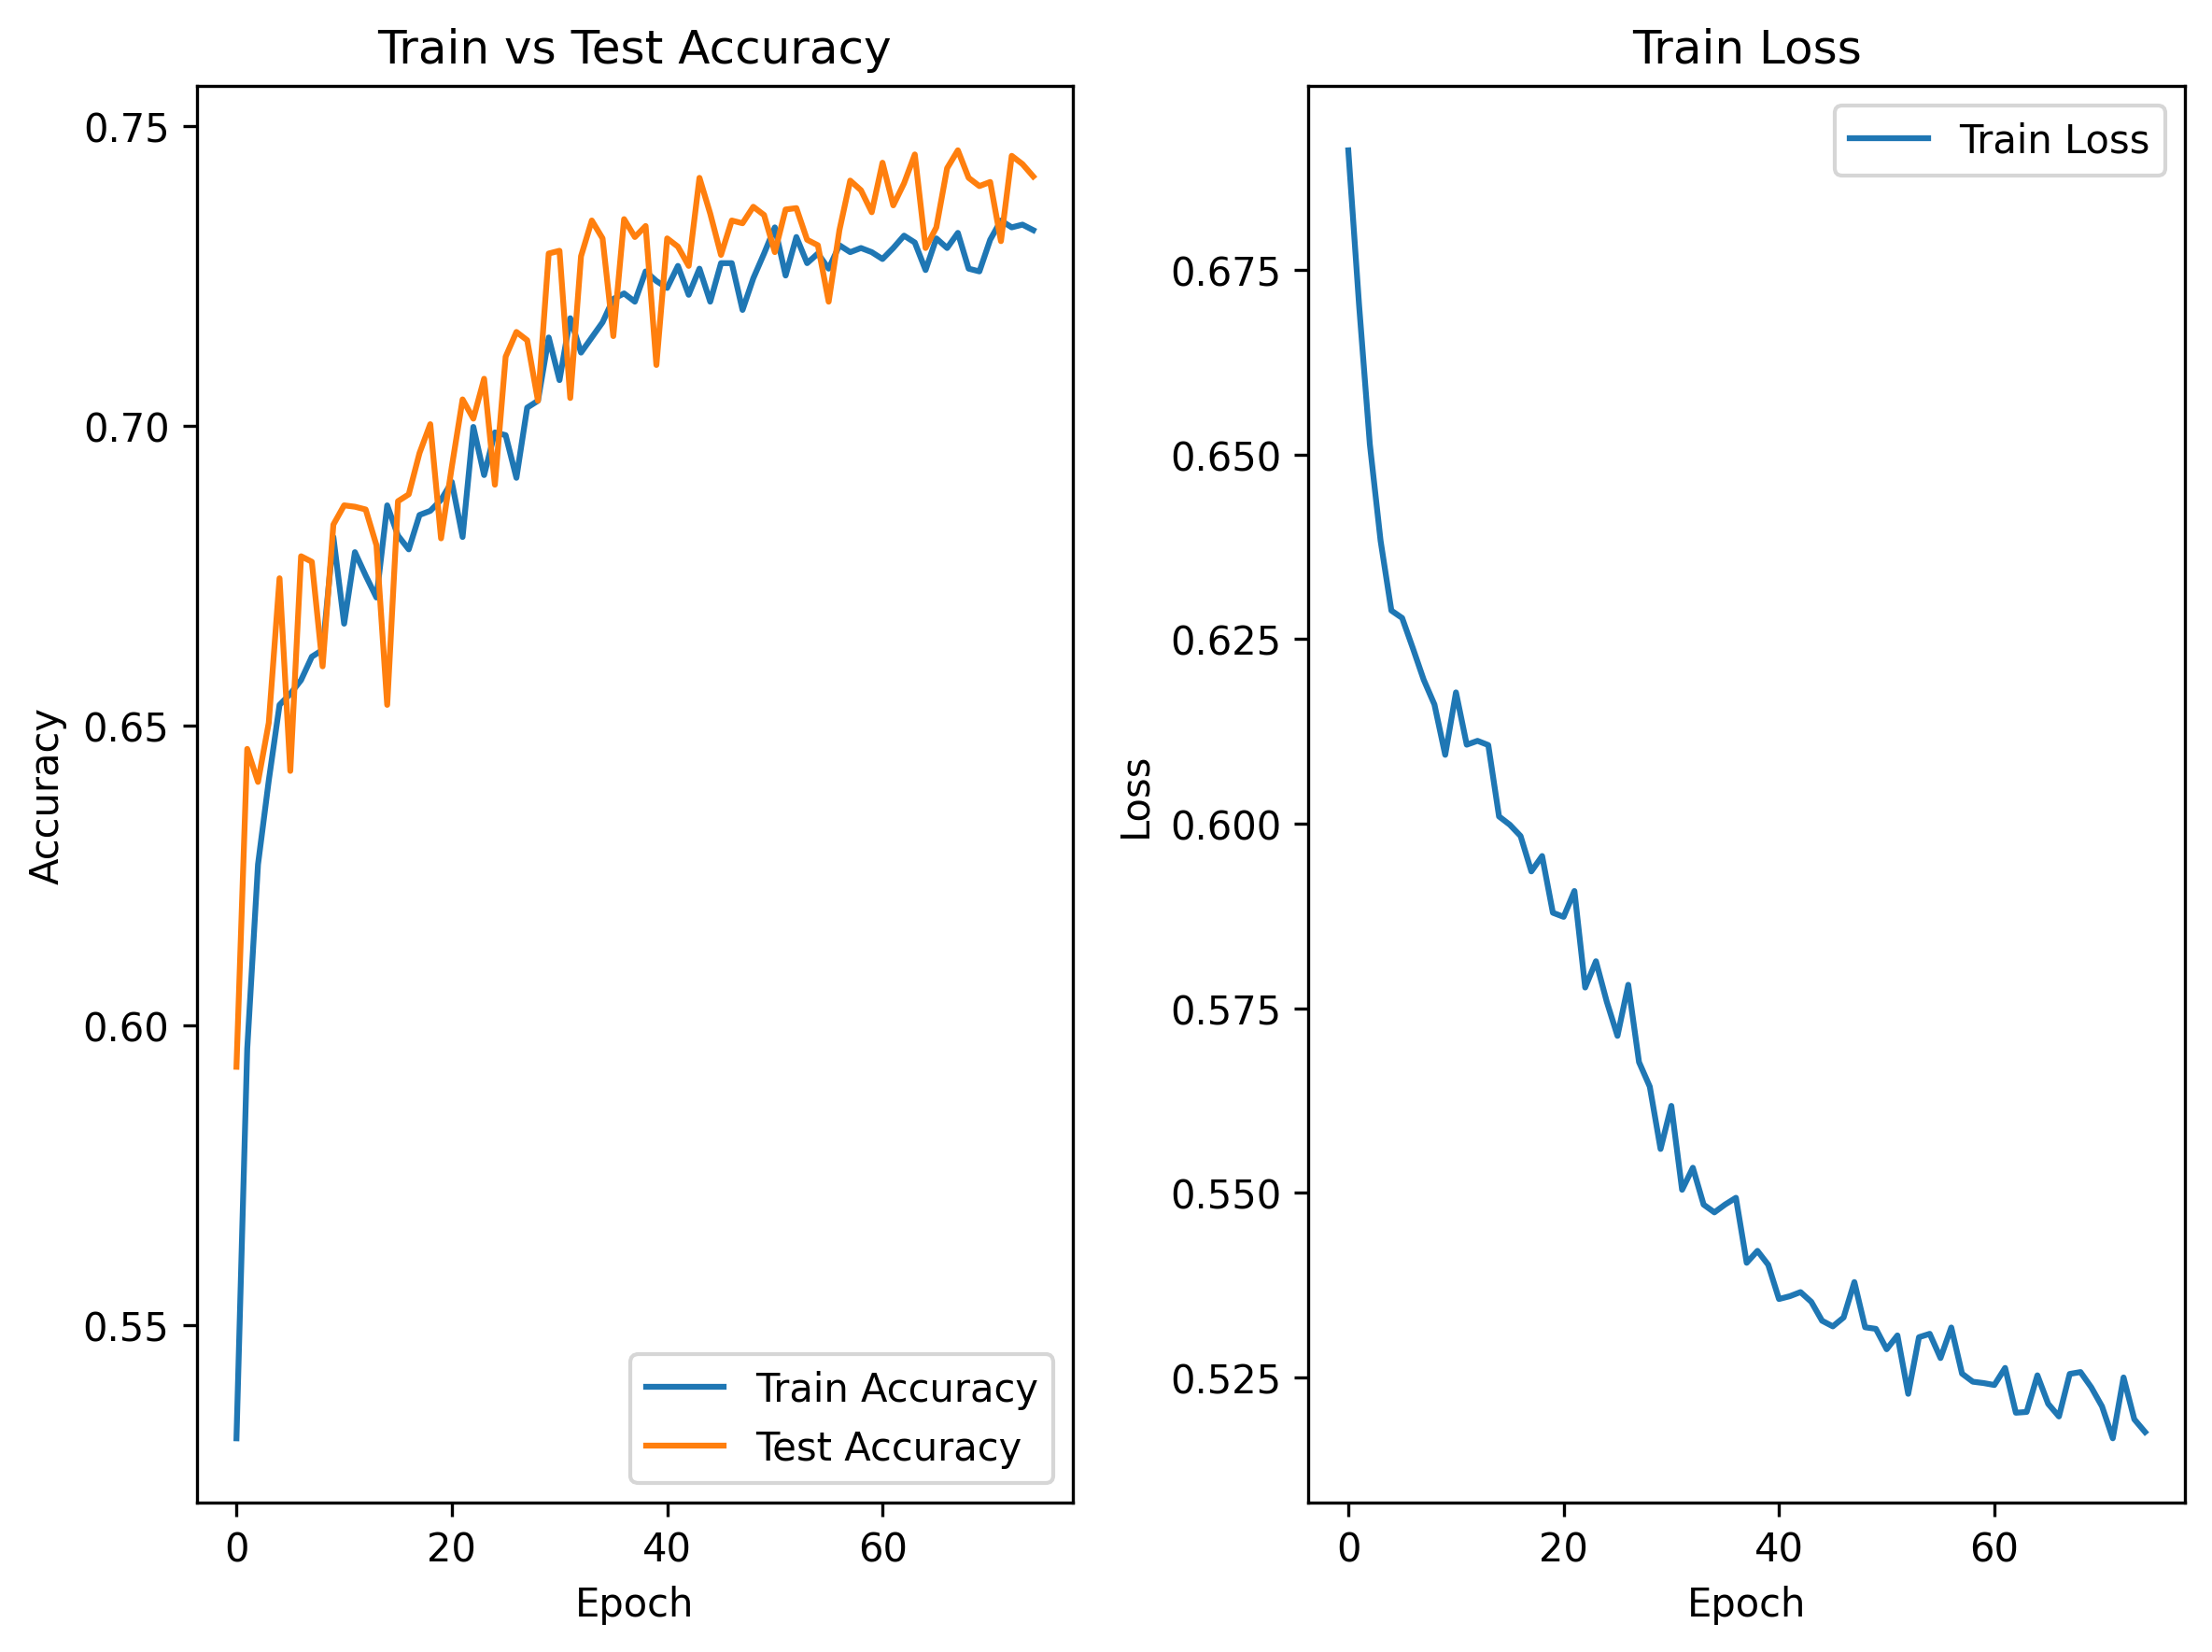

Predictions and probabilities saved to GAT_PAMPA_test_new.xlsx
Test Metrics: {'MCC': 0.4792669438332765, 'Kappa': 0.4769814490843943, 'Sensitivity': 0.6701234567901234, 'Specificity': 0.8036020583190394, 'F1 Score': 0.7067708333333332, 'Precision': 0.7476584022038567, 'AUC': 0.8310722529275989, 'Brier Loss': 0.1658208238248931, 'Accuracy': 0.7415652972228598}


/home/acdsd/psi4conda/envs/compound_library/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Predictions and probabilities saved to GAT_PAMPA_external_new.xlsx
External Validation Metrics: {'MCC': 0.01035299953948371, 'Kappa': 0.009396807849098354, 'Sensitivity': 0.045454545454545456, 'Specificity': 0.9615384615384616, 'F1 Score': 0.06349206349206349, 'Precision': 0.10526315789473684, 'AUC': 0.559594816947758, 'Brier Loss': 0.11038082891048313, 'Accuracy': 0.8786008230452675}


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATv2Conv, global_mean_pool
from rdkit import Chem
from torch_geometric.data import Data
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (roc_auc_score, accuracy_score, 
                             matthews_corrcoef, cohen_kappa_score,
                             brier_score_loss, confusion_matrix, 
                             precision_score, f1_score, recall_score)

# Helper function to convert SMILES to molecular graphs
def atom_features(atom):
    """Function to generate features for an atom."""
    return torch.tensor([
        atom.GetAtomicNum(),        # Atomic number
        atom.GetDegree(),           # Degree (number of bonds)
        atom.GetFormalCharge(),     # Formal charge
        int(atom.GetIsAromatic())   # Aromaticity
    ], dtype=torch.float)

def mol_to_graph(smiles):
    """Function to convert SMILES string to a graph with node features."""
    mol = Chem.MolFromSmiles(smiles)
    atoms = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.stack(atoms, dim=0)  # Stack node features
    
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])  # Add both directions since the graph is undirected

    edge_index = torch.tensor(edge_index).t().contiguous()
    
    return Data(x=x, edge_index=edge_index)

# External validation Dataset loading function   
def load_dataset(file_path):
    """Load dataset and convert SMILES to molecular graphs."""
    df = pd.read_excel(file_path)
    graphs = []
    for i, row in df.iterrows():
        smiles = row['smiles']
        target = row['Target']
        graph = mol_to_graph(smiles)
        graph.y = torch.tensor([target], dtype=torch.float)
        graphs.append(graph)
    return graphs

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.fc1 = torch.nn.Linear(hidden_channels * num_heads, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)  # Regularization

    def forward(self, data):
        x = data.x.float()
        batch = data.batch.long()  
        edge_index = data.edge_index.long()
        # Two graph attention layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        # Pooling to obtain graph-level representations
        x = global_mean_pool(x, batch)
        # Fully connected layers for classification
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)  # Binary classification

# Train function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data).squeeze()  # Remove unnecessary dimensions
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out > 0.5).float()  # Binary prediction
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

# Test function
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data).squeeze()
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Test function with metrics calculation
def test_with_metrics(model, loader,output_file):
    model.eval()
    y_true = []
    y_pred_probs = []
    
    for data in loader:
        out = model(data).squeeze()
        y_true.extend(data.y.numpy())  # Collect true labels
        y_pred_probs.extend(out.detach().numpy())  # Collect predicted probabilities

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Threshold the probabilities to get binary predictions
    y_pred = (y_pred_probs > 0.5).astype(int)

        # Create a DataFrame for storing probabilities, binary predictions, and true labels
    results_df = pd.DataFrame({
        'True Label': y_true,
        'Predicted Probability': y_pred_probs,
        'Binary Prediction': y_pred
    })

    # Save to an Excel file
    results_df.to_excel(output_file, index=False)
    print(f"Predictions and probabilities saved to {output_file}")

    # Calculate metrics
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)  # AUC based on probabilities
    brier_loss = brier_score_loss(y_true, y_pred_probs)
    accuracy = accuracy_score(y_true, y_pred)  # Calculate accuracy

    return {
        "MCC": mcc,
        "Kappa": kappa,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "F1 Score": f1,
        "Precision": precision,
        "AUC": auc,
        "Brier Loss": brier_loss,
        "Accuracy": accuracy,
    }

# Main function to load data, define model, train, and evaluate
def main():
    # Load dataset and split into train/test sets    
#    file_path = 'molecules.xlsx'  # Update with your file path
#    graphs = load_dataset(file_path)
#    train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)


# Load train adn test sets separate    
    file_path_train = 'train_smiles.xlsx'  # Update with your file path
    file_path_test = 'train_smiles.xlsx'
    train_graphs = load_dataset(file_path_train)
    test_graphs = load_dataset(file_path_test)


    # Model setup with best hyperparameters
    best_params = {
        'hidden_channels': 44,
        'learning_rate': 0.0012835792049620406,
        'dropout_rate': 0.13696652127393172,
        'num_epochs': 75,
    }
    
    # Create PyTorch Geometric DataLoader 
    train_loader = DataLoader(train_graphs, batch_size=27, shuffle=True)  # Use optimal batch size
    test_loader = DataLoader(test_graphs, batch_size=27, shuffle=False)

    # Model setup
    model = GAT(in_channels=4, hidden_channels=best_params['hidden_channels'], out_channels=1, num_heads=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    criterion = torch.nn.BCELoss()  # Binary cross-entropy loss for binary classification

    # Lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(best_params['num_epochs']):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_acc = test(model, test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Plot accuracy and loss
    plt.figure(figsize=(8, 6), dpi=300)
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('PAMPA_gat_new.png')
    plt.show()

    test_metrics = test_with_metrics(model, test_loader, output_file='GAT_PAMPA_test_new.xlsx')
    print("Test Metrics:", test_metrics)

    # External validation
    external_file_path = 'external_smiles.xlsx'  # Update with your external file path
    external_graphs = load_dataset(external_file_path)
    external_loader = DataLoader(external_graphs, batch_size=27, shuffle=False)

    # Evaluate on external dataset
    external_metrics = test_with_metrics(model, external_loader,output_file='GAT_PAMPA_external_new.xlsx')
    print("External Validation Metrics:", external_metrics)

if __name__ == "__main__":
    main()
